In [1]:
import pandas as pd
from sklearn.datasets import load_digits
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mode
from sklearn import metrics
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics.cluster import fowlkes_mallows_score
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import warnings; warnings.simplefilter('ignore')  # Fix NumPy issues.
import numpy as np

### 1. k-means on digits

Use K-means clustering on the MNIST dataset (which can be imported with `from sklearn.datasets import load_digits`) to learn to identify the 10 digits in an unsupervised manner.

1. Plot the `cluster_centers_` from a kmeans clustering (which should be shape `(10,64)`) onto a `8x8` grid (hint: use `kmeans.cluster_centers_.reshape`)

2. Reorganize the clusters so that each of your learned clusters labels overlap with the true label (eg. if the digit 4 has the cluster label 9, you want to remap it to 4). Hint: You can use the statistical mode of your clusters and the real label to match them

3. Now that your cluster labels are matched to the supervised learning labels, check the classification accuracy of your clustering model (accuracy score and confusion matrix). Give a two paragraph interpretation.

4. Use the Fowlkes-Mallows score to evaluate your clustering against the true labels. Give a two paragraph interpretation comparing to your result in #3.

In [2]:
digits  = load_digits()

In [3]:
digits.DESCR.split('\n')

['.. _digits_dataset:',
 '',
 'Optical recognition of handwritten digits dataset',
 '--------------------------------------------------',
 '',
 '**Data Set Characteristics:**',
 '',
 '    :Number of Instances: 5620',
 '    :Number of Attributes: 64',
 '    :Attribute Information: 8x8 image of integer pixels in the range 0..16.',
 '    :Missing Attribute Values: None',
 "    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)",
 '    :Date: July; 1998',
 '',
 'This is a copy of the test set of the UCI ML hand-written digits datasets',
 'https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits',
 '',
 'The data set contains images of hand-written digits: 10 classes where',
 'each class refers to a digit.',
 '',
 'Preprocessing programs made available by NIST were used to extract',
 'normalized bitmaps of handwritten digits from a preprinted form. From a',
 'total of 43 people, 30 contributed to the training set and different 13',
 'to the test set. 32x32 bitmaps are

Answer 1.1


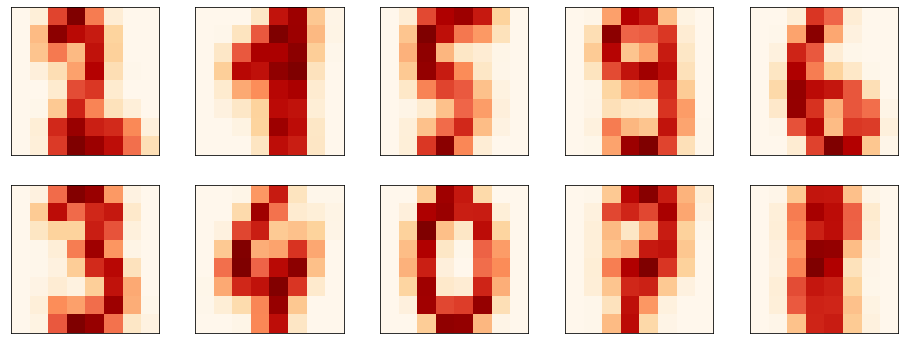

Answer 1.3 Accuracy Scores and Confusion Matrices

accuracy_score_train: 0.79
accuracy_score_test: 0.79

Classification report for training data

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       123
           1       0.62      0.31      0.41       127
           2       0.87      0.82      0.84       125
           3       0.86      0.84      0.85       127
           4       0.98      0.93      0.96       117
           5       0.89      0.81      0.85       109
           6       0.96      0.98      0.97       124
           7       0.86      0.91      0.88       117
           8       0.42      0.59      0.49       122
           9       0.59      0.76      0.67       112

    accuracy                           0.79      1203
   macro avg       0.80      0.79      0.79      1203
weighted avg       0.80      0.79      0.79      1203


Classification report for test data

              precision    recall  f1-score   support

  

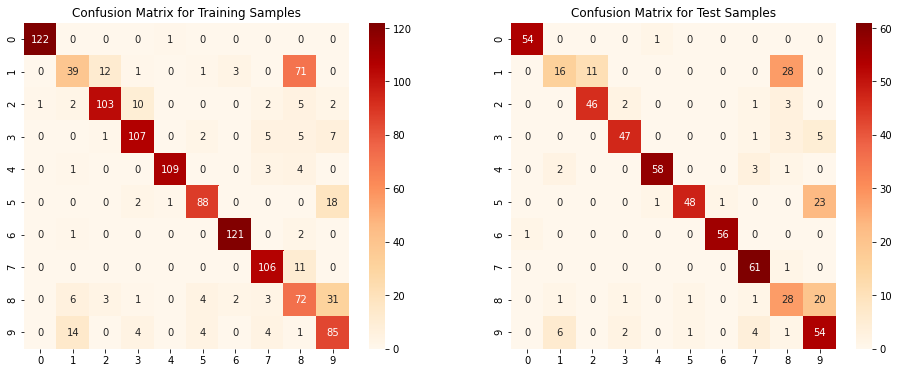


The kmeans model on the test data is 0.79 times accurate. This result is lower than with a supervised model such as logisitic regression. The model seems to be more inacurate for predicting 1s and 8s.Themodel seems to misclassify also the 9s. Otherwise, the diagonal line of the confusion matrix is typically darker thanthe rest of the matrix which supports that the model is generally accurate.

Answer 1.4

The fowlkes mallows score is 0.69 on the test data. According to sklearn documentation, the fowlkes mallows score ranges from 0 to 1. A high number indicates a good similarity between two clusters. The metric is closer to 1 suggest that the twoclusters share similarities and is in agreement with results obtained in 1.3.


In [4]:
#1.1 Plot the cluster_centers_ from a kmeans clustering (which should be shape (10,64)) onto a 8x8 grid (hint: use
#kmeans.cluster_centers_.reshape)

N_CLUSTERS = 10

X = digits.data
y = digits.target

X_normalized = preprocessing.normalize(X, norm='l2')
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_normalized, y, test_size=0.33, random_state=42)

model = KMeans(n_clusters = N_CLUSTERS)
model.fit(X_train)
y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)
centers = model.cluster_centers_.reshape(10, 8, 8)

print('Answer 1.1')
fig, axes = plt.subplots(2, 5, figsize = (16, 6), subplot_kw=dict(xticks=[], yticks=[]))
idx = 0
for i in range(2):
    for j in range(5):
        axes[i, j].imshow(centers[idx], cmap="OrRd", interpolation="nearest")
        idx+=1
plt.show()

#1.2 Reorganize the clusters so that each of your learned clusters labels overlap with the true label (eg. if the digit 4
#has the cluster label 9, you want to remap it to 4). Hint: You can use the statistical mode of your clusters and the real 
#label to match them

dct= {}
for i in range(10):
    dct[i] = mode(y_train[y_train_predict == i])
y_train_predict = list(map(dct.get, y_train_predict))
y_test_predict = list(map(dct.get, y_test_predict))


#1.3 Now that your cluster labels are matched to the supervised learning labels, check the classification accuracy of your
#clustering model (accuracy score and confusion matrix). Give a two paragraph interpretation.
accuracy_score_train = accuracy_score(y_train,y_train_predict)
accuracy_score_test = accuracy_score(y_test,y_test_predict)


accuracy_score_dict = {'accuracy_score_train' : accuracy_score_train,
                      'accuracy_score_test': accuracy_score_test}

print('Answer 1.3 Accuracy Scores and Confusion Matrices\n')
for k,v in accuracy_score_dict.items():
    print(f'{k}: {v:0.2f}')

print('\nClassification report for training data\n\n'+metrics.classification_report(y_train, y_train_predict))
print('\nClassification report for test data\n\n'+metrics.classification_report(y_test, y_test_predict))


# Confusion Matrices
confusion_matrix_train = metrics.confusion_matrix(y_train, y_train_predict)
confusion_matrix_test = metrics.confusion_matrix(y_test, y_test_predict)

#Graph confusion matrix
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,6))
sns.heatmap(confusion_matrix_train , annot=True, fmt="d", cmap="OrRd" ,ax = ax1)
ax1.set_title("Confusion Matrix for Training Samples")
sns.heatmap(confusion_matrix_test , annot=True, fmt="d", cmap="OrRd", ax = ax2)
ax2.set_title("Confusion Matrix for Test Samples")
plt.show()

print(f'''
The kmeans model on the test data is {accuracy_score_dict['accuracy_score_test']:0.2f} times accurate. This result is lower \
than with a supervised model such as logisitic regression. The model seems to be more inacurate for predicting 1s and 8s.The\
model seems to misclassify also the 9s. Otherwise, the diagonal line of the confusion matrix is typically darker than\
the rest of the matrix which supports that the model is generally accurate.''')

#1.4 Use the Fowlkes-Mallows score to evaluate your clustering against the true labels. Give a two paragraph interpretation
#comparing to your result in #3.

f_metric_test = fowlkes_mallows_score(y_test, y_test_predict)

print(f'\nAnswer 1.4\n\nThe fowlkes mallows score is {f_metric_test:0.2f} on the test data. According to sklearn documentation, the fowlkes mallows score ranges from\
 0 to 1. A high number indicates a good similarity between two clusters. The metric is closer to 1 suggest that the two\
clusters share similarities and is in agreement with results obtained in 1.3.')

### 2: Image Compression second pass

Use any the clustering algorithms we see to produce what you think is the best image compression ratio that is **visually indistinguishable** from the original image (recall in the lecture the result was very compressed but also much uglier)

Justify your choice and process in 3 paragraphs.

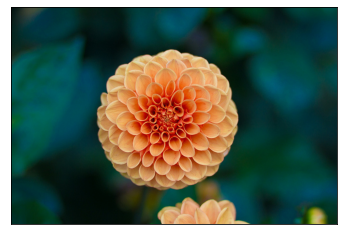

In [5]:
from sklearn.datasets import load_sample_image
img = load_sample_image("flower.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(img)
data = img / 255.0 # use 0...1 scale
data = data.reshape(427 * 640, 3)


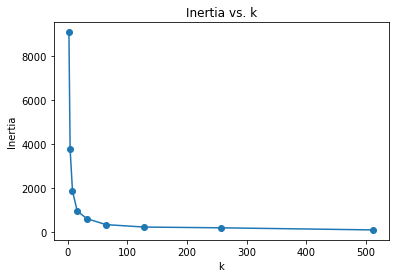

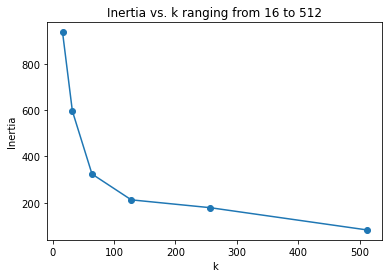

The Elbow method was used to estimate the number of clusters. Basically the optimal k can be estimated by finding the inertia for different number of clusters. According to sklearn documentation, the inertia is a measure of how internally coherent clusters are. The optimal k usually falls where the inertia term decreases significantly at a slower rate. This points is called the elbow of the plot (i.e. inflection point). In this case, the elbow is located around 128 which corresponds to the range of values where the image is visually indistinguishable from the original. The following figures tends to be coherent with the Elbow method results. The comparison of images shows that at k equal to 64, differences with the original image can still be observed.


In [6]:
#The Elbow Method

ks = [2**i for i in range(1, 10)]
kmeans_models = {}
inertias = []

for k in ks:
    kmeans_models[k] = MiniBatchKMeans(k)
    kmeans_models[k].fit(data)
    inertias.append(kmeans_models[k].inertia_)

#Graph of Inertia vs. k number of clusters
plt.title('Inertia vs. k')
plt.plot(ks, inertias, marker = 'o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()

#Close-up view of Inertia vs. k number of clusters
plt.plot(ks[3:],inertias[3:], marker = 'o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Inertia vs. k ranging from 16 to 512')
plt.show()

print('The Elbow method was used to estimate the number of clusters. Basically the optimal k can be estimated by finding the \
inertia for different number of clusters. According to sklearn documentation, the inertia is a measure of how internally \
coherent clusters are. The optimal k usually falls where the inertia term decreases significantly at a slower rate. \
This points is called the elbow of the plot (i.e. inflection point). In this case, the elbow is located around 128 which corresponds \
to the range of values where the image is visually indistinguishable from the original. The following figures tends to \
be coherent with the Elbow method results. The comparison of images shows that at k equal to 64, differences with the original \
image can still be observed.')

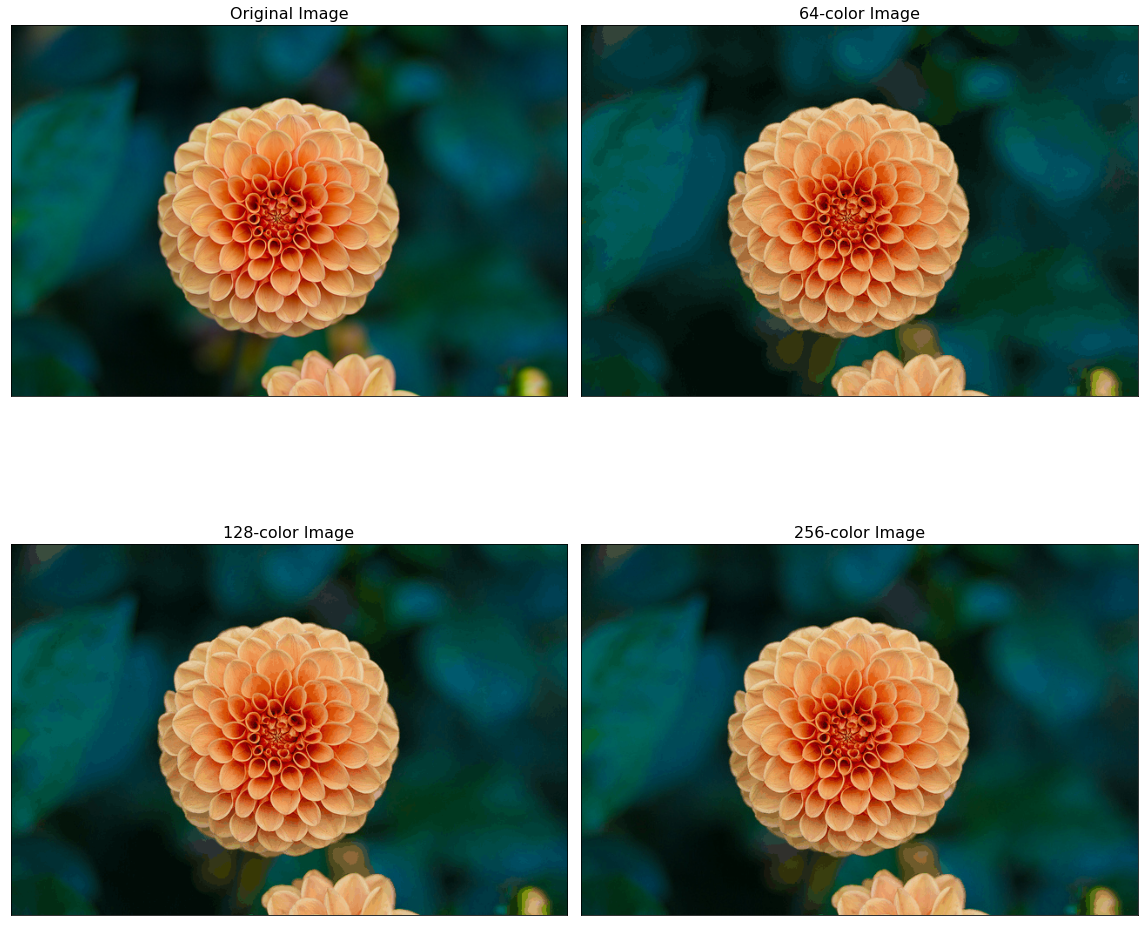

In [7]:
#Images according to different k

ks = [64, 128, 256,'original',]
imgs_recolored = {}
for i in range(3):
    new_colors = kmeans_models[ks[i]].cluster_centers_[kmeans_models[ks[i]].predict(data)]
    imgs_recolored[ks[i]] = new_colors.reshape(img.shape)

fig, ax = plt.subplots(2, 2, figsize=(16, 16), subplot_kw=dict(xticks=[], yticks=[]))

ax[0,0].imshow(img)
ax[0,0].set_title('Original Image', size=16)
ax[0,1].imshow(imgs_recolored[64])
ax[0,1].set_title('64-color Image', size=16)
ax[1,0].imshow(imgs_recolored[128])
ax[1,0].set_title('128-color Image', size=16)
ax[1,1].imshow(imgs_recolored[256])
ax[1,1].set_title('256-color Image', size=16)
plt.tight_layout()
plt.show()

# 3. Clustering on Colleges

This question will use the data from `college.csv`

1. Use clustering with `k=2` on all data except whether the college is private of not. Try to match it best to the private/public college split (hint: don't forget to normalize your features!). Evaluate it in terms of classification metrics and clustering metrics.

2. Knowing what you found in `3.1`, find the best overall clustering with the k of your choice. Make an argument and a visualization of the clusters (with two relevant statistics) to demonstrate why you think your clustering is good.

In [8]:
#3.1 

N_CLUSTERS = 2

df = pd.read_csv('data/college.csv')
df = df.copy()

drop_cols = ['Unnamed: 0', 'Private']
X  = df.drop(drop_cols, axis = 1)
y = df['Private'].map({'Yes': 1 ,'No':0})

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, random_state=42)
X_train_normalized = preprocessing.normalize(X_train, norm='l2')
X_test_normalized = preprocessing.normalize(X_test, norm='l2')

kmeans = KMeans(n_clusters = N_CLUSTERS).fit(X_train_normalized)
dct = {1:0, 0:1}
y_train_predict = list(map(dct.get, kmeans.predict(X_train_normalized)))
y_test_predict = list(map(dct.get, kmeans.predict(X_test_normalized)))




In [9]:
#Classification metrics

print("Classification report for training data for k = 2 \n")
print(classification_report(y_train, y_train_predict))
print("Classification report for testing data for k = 2\n")
print(classification_report(y_test, y_test_predict))



Classification report for training data for k = 2 

              precision    recall  f1-score   support

           0       0.09      0.26      0.14       145
           1       0.10      0.03      0.05       375

    accuracy                           0.10       520
   macro avg       0.10      0.15      0.09       520
weighted avg       0.10      0.10      0.07       520

Classification report for testing data for k = 2

              precision    recall  f1-score   support

           0       0.09      0.28      0.14        67
           1       0.09      0.03      0.04       190

    accuracy                           0.09       257
   macro avg       0.09      0.15      0.09       257
weighted avg       0.09      0.09      0.07       257



In [10]:
#Clustering metrics

labels_true = y_test
labels_pred = y_test_predict

adjusted_rand_score = metrics.adjusted_rand_score(labels_true, labels_pred)
adjusted_mutual_info_score = metrics.adjusted_mutual_info_score(labels_true, labels_pred)
homogeneity_score = metrics.homogeneity_score(labels_true, labels_pred)
completeness_score = metrics.completeness_score(labels_true, labels_pred)
v_measure_score = metrics.v_measure_score(labels_true, labels_pred)
fowlkes_mallows_score = metrics.fowlkes_mallows_score(labels_true, labels_pred)

clu_metrics = {
    'adjusted_rand_score' : adjusted_rand_score,
    'adjusted_mutual_info_score' : adjusted_mutual_info_score,
    'homogeneity_score' : homogeneity_score,
    'completeness_score' : completeness_score,
    'v_measure_score': v_measure_score,
    'fowlkes_mallows_score' : fowlkes_mallows_score
}



print('Clustering metrics for k = 2\n')
for k,v in clu_metrics.items():
    print(f'{k} : {v:0.2f}')


Clustering metrics for k = 2

adjusted_rand_score : 0.63
adjusted_mutual_info_score : 0.48
homogeneity_score : 0.46
completeness_score : 0.52
v_measure_score : 0.49
fowlkes_mallows_score : 0.87


The accuracy and f1 score are all higher than 0.8 which is good. As for the adjusted rand score and folkes mallows score is closer to 1 than 0. This indicates that it is not a perfect association between the true values and predicted values. However, the metric suggests in general that the predications are better than randomness. The rest of the metrics are around half way between 0 and 1 which are not as good as the previous metrics but still greater than 0. 



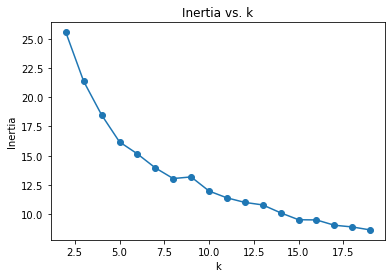

In [11]:
#3.2 Elbow method

ks = range(2,20)
kmeans_models = {}
inertias = []


for k in ks:
    kmeans_models[k] =  MiniBatchKMeans(k).fit(X_train_normalized)
    inertias.append(kmeans_models[k].inertia_)

#Graph of Inertia vs. k number of clusters
plt.title('Inertia vs. k')
plt.plot(ks, inertias, marker = 'o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.585803103928166
For n_clusters = 3 The average silhouette_score is : 0.40587943308735713
For n_clusters = 4 The average silhouette_score is : 0.3351384087651876
For n_clusters = 5 The average silhouette_score is : 0.3071217207300303
For n_clusters = 6 The average silhouette_score is : 0.22154358092806095


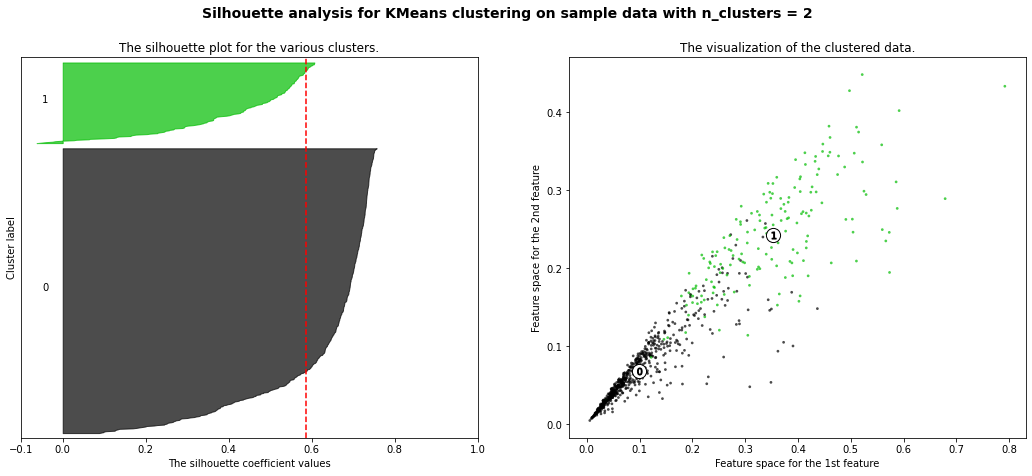

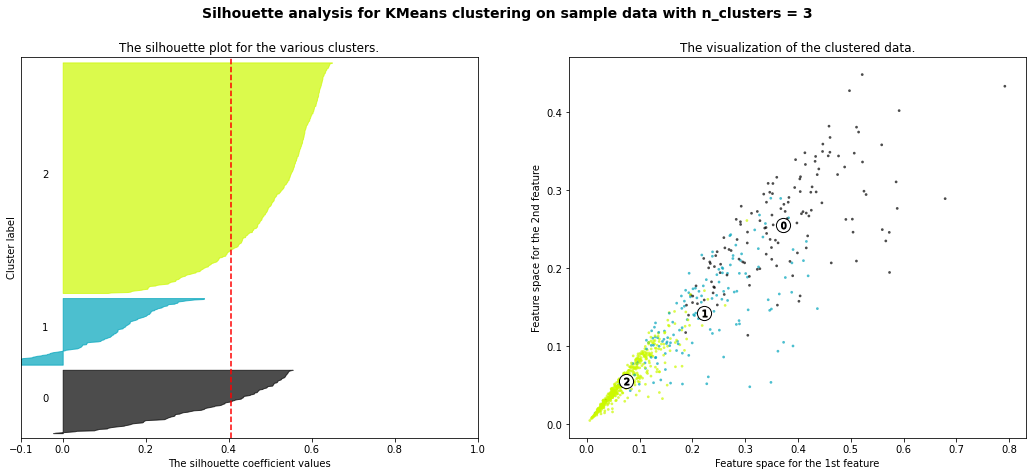

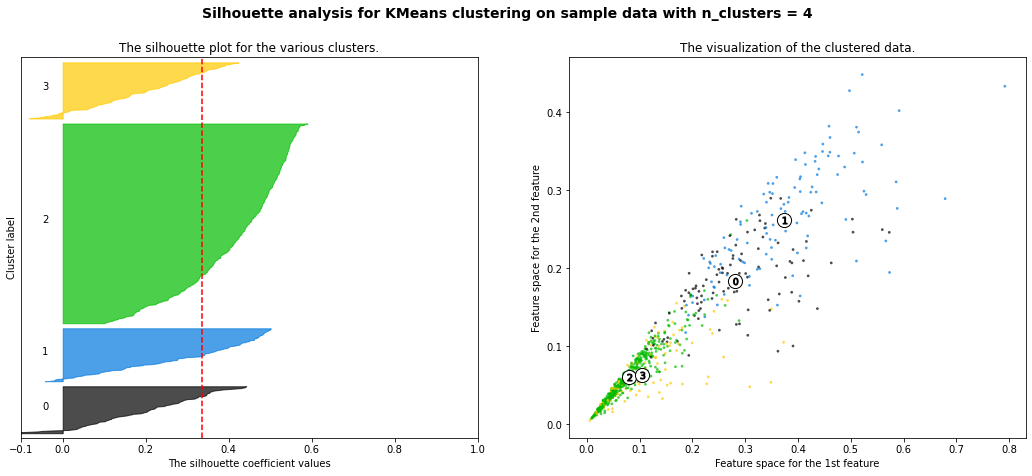

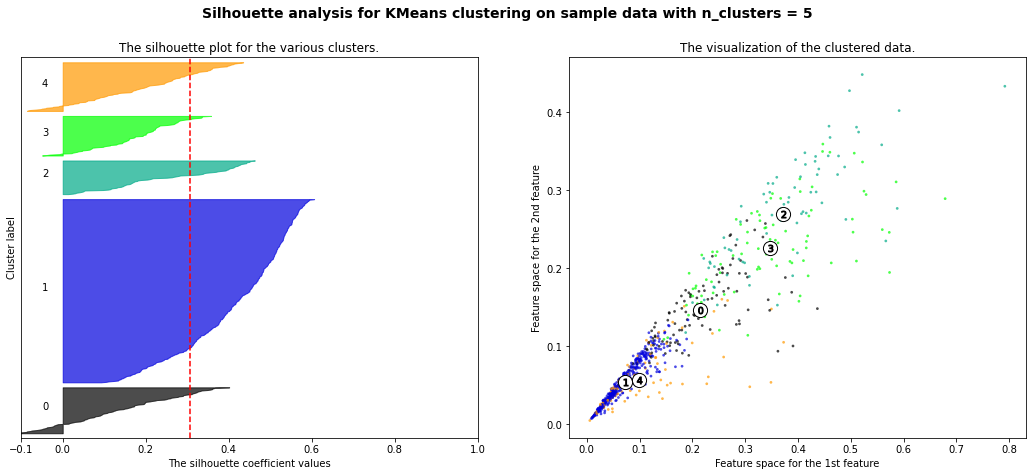

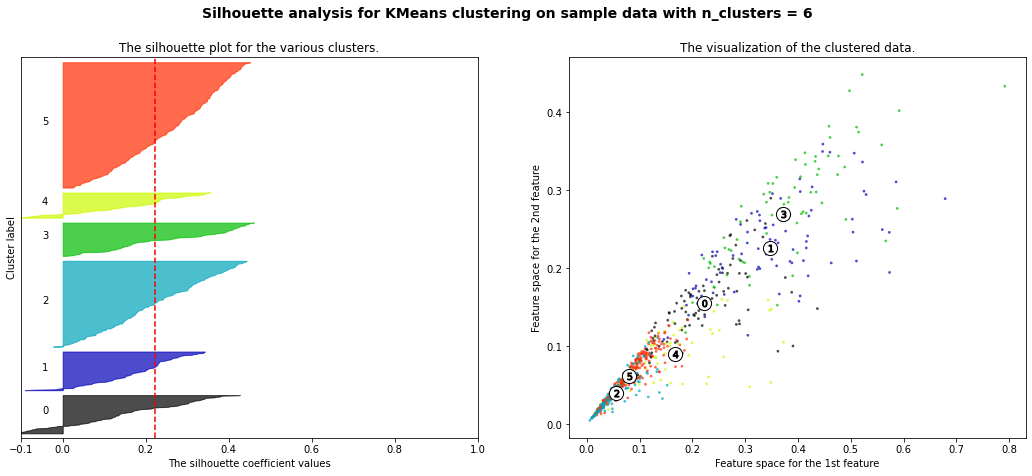

In [12]:
#3.2 Silhouette coefficien approach


#Selecting the number of clusters with silhouette analysis on KMeans clustering
df = pd.read_csv('data/college.csv')
df = df.copy()
drop_cols = ['Unnamed: 0', 'Private']
X = df.drop(drop_cols, axis = 1)
X = preprocessing.normalize(X, norm='l2')
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()


The Elbow method is not conclusive to determine k since the inflection point on the curve is not obvious. The silhouette analysis method suggest a k of 2 is better given also that its average score is greatest among the different number of clusters considered. Given that the value to predict can take on one of two values that is private or not private, it seems reasonable to expect 2 clusters.